Libraries Import

In [47]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import time
import copy
import matplotlib.pyplot as plt

In [48]:
# Stage 1 — Transform-free Dataset

class CoralClassificationDataset(Dataset):
    """
    CSV columns required:
      - 'Name'         : filename of the image
      - 'Class'        : class name
      - 'Folder Path'  : folder containing the image
    """
    def __init__(self, csv_file: str):
        self.data_frame = pd.read_csv(csv_file)

        # Basic validation
        needed = {'Name', 'Class', 'Folder Path'}
        missing = needed.difference(self.data_frame.columns)
        if missing:
            raise ValueError(f"CSV is missing required columns: {missing}")

        # Normalize strings
        self.data_frame['Name'] = self.data_frame['Name'].astype(str).str.strip()
        self.data_frame['Class'] = self.data_frame['Class'].astype(str).str.strip()
        self.data_frame['Folder Path'] = self.data_frame['Folder Path'].astype(str).str.strip()

        # Map classes → indices
        self.classes = sorted(self.data_frame['Class'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Build sample list
        self.samples = []
        for _, row in self.data_frame.iterrows():
            full_path = os.path.join(row['Folder Path'], row['Name'])
            if os.path.exists(full_path):
                self.samples.append((full_path, self.class_to_idx[row['Class']]))
            else:
                print(f"Warning: Image not found: {full_path} — skipping.")

        if not self.samples:
            raise RuntimeError("No valid image paths were found from the CSV.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')  # ← return PIL
        return image, label

In [49]:
##Stage 2 - Model Configuration and Setup
# Define device to train on (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [50]:
# Model selection (InceptionV3)
model_name = "inception_v3"

# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

In [51]:
# Define the transformations based on the chosen model
# For InceptionV3, the input size is 299x299
if model_name == "inception_v3":
    input_size = 299
    # InceptionV3 expects input in [0, 1] and then normalized
    # ToTensor() automatically scales to [0, 1]
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size), # Randomly crop and resize
            transforms.RandomHorizontalFlip(),       # Data augmentation
            transforms.ToTensor(),                   # Scales to [0, 1]
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
elif model_name == "resnet50" or model_name == "densenet121":
    input_size = 224
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
elif model_name == "efficientnet_b0":
    input_size = 224 # EfficientNetB0 expects 224x224
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
else:
    raise ValueError("Model not supported. Choose from 'inception_v3', 'resnet50', 'densenet121', 'efficientnet_b0'.")

def transform_collate(batch, tf):
    """
    batch: list of (PIL.Image, int)
    tf: torchvision transform to apply to each PIL
    returns: (B,C,H,W) tensor, (B,) long tensor
    """
    pil_images, labels = zip(*batch)  # unzip
    labels = torch.tensor(labels, dtype=torch.long)
    images = torch.stack([tf(img) for img in pil_images])  # apply transform to each
    return images, labels

In [52]:
# Stage 2 — Splits & Loaders

def pil_collate(batch):
    """Keep PIL images as a list; stack labels only."""
    images, labels = zip(*batch)              # images: tuple of PILs
    labels = torch.tensor(labels, dtype=torch.long)
    return list(images), labels

csv_path = '/kaggle/input/corals-morphology-classification/01-Final Data set - Additional/Data_set_csv_v1.csv'
full_dataset = CoralClassificationDataset(csv_file=csv_path)
num_classes = len(full_dataset.classes)
print(f"Classes ({num_classes}): {full_dataset.classes}")

# Ratios as you used (70/15/15)
total_size = len(full_dataset)
train_size = int(0.70 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_set, val_set, test_set = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible
)

batch_size = 32  # keep whatever you use in the notebook
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4, collate_fn=pil_collate)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=pil_collate)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=pil_collate)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
print(f"Split sizes → Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Classes (4): ['Boulder Coral', 'Branched Coral', 'Plate Coral', 'Soft Coral']
Split sizes → Train: 474, Val: 101, Test: 103


In [53]:
from torch.utils.data import DataLoader

batch_size = 32  # or your preferred value

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda batch: transform_collate(batch, data_transforms['train'])
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=lambda batch: transform_collate(batch, data_transforms['val'])
)

test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=lambda batch: transform_collate(batch, data_transforms['test'])
)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

imgs, lbls = next(iter(train_loader))
print(imgs.shape, lbls.shape)  # -> torch.Size([B, 3, 224, 224]) torch.Size([B])


torch.Size([32, 3, 299, 299]) torch.Size([32])


In [54]:
# 4 - Model Loading and Modification
def initialize_model(model_name, num_classes):
    model = None
    if model_name == "inception_v3":
        model = models.inception_v3(weights='IMAGENET1K_V1')
        num_ftrs_aux = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        print(f"Initialized InceptionV3 model. Output features changed to {num_classes}.")
    elif model_name == "resnet50":
        model = models.resnet50(weights='IMAGENET1K_V1')
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        print(f"Initialized ResNet50 model. Output features changed to {num_classes}.")
    elif model_name == "densenet121":
        model = models.densenet121(weights='IMAGENET1K_V1')
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        print(f"Initialized DenseNet121 model. Output features changed to {num_classes}.")
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        print(f"Initialized EfficientNetB0 model. Output features changed to {num_classes}.")
    else:
        raise ValueError("Model not supported.")
    return model

model = initialize_model(model_name, num_classes)
model = model.to(device)

Initialized InceptionV3 model. Output features changed to 4.


In [55]:
# 5 - Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimiz = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
# 6 - Training Loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if model_name == "inception_v3" and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            elif phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if it's the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return model, history

# Start training
model_ft, history = train_model(model, dataloaders, criterion, optimiz, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 1.2958 Acc: 0.6477
val Loss: 4.8833 Acc: 0.2574

Epoch 1/19
----------
train Loss: 0.9507 Acc: 0.7278
val Loss: 1.8468 Acc: 0.6436

Epoch 2/19
----------
train Loss: 0.9495 Acc: 0.7658
val Loss: 1.9626 Acc: 0.5941

Epoch 3/19
----------
train Loss: 0.8399 Acc: 0.7743
val Loss: 0.6080 Acc: 0.7327

Epoch 4/19
----------
train Loss: 0.7251 Acc: 0.8122
val Loss: 0.5969 Acc: 0.8020

Epoch 5/19
----------
train Loss: 0.7161 Acc: 0.8376
val Loss: 1.0965 Acc: 0.6832

Epoch 6/19
----------
train Loss: 0.7217 Acc: 0.8165
val Loss: 0.5835 Acc: 0.8119

Epoch 7/19
----------
train Loss: 0.5591 Acc: 0.8586
val Loss: 0.9543 Acc: 0.7030

Epoch 8/19
----------
train Loss: 0.6472 Acc: 0.8502
val Loss: 0.6040 Acc: 0.7525

Epoch 9/19
----------
train Loss: 0.5841 Acc: 0.8586
val Loss: 0.9485 Acc: 0.7129

Epoch 10/19
----------
train Loss: 0.5518 Acc: 0.8671
val Loss: 0.5057 Acc: 0.8218

Epoch 11/19
----------
train Loss: 0.5237 Acc: 0.8755
val Loss: 0.7626 Acc: 0.7723

Ep

In [57]:
# 7 - Evaluation on Test Set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    return test_acc, predictions, true_labels

test_accuracy, test_predictions, test_true_labels = evaluate_model(model_ft, dataloaders['test'], criterion)

Test Loss: 0.3483 Acc: 0.9223


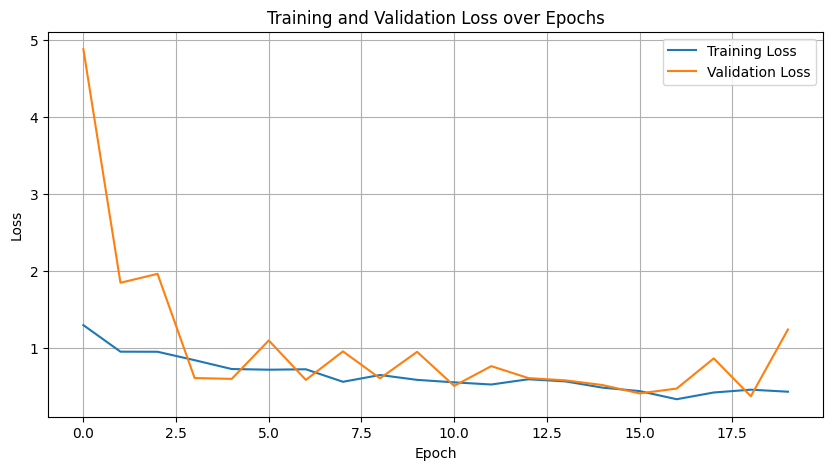

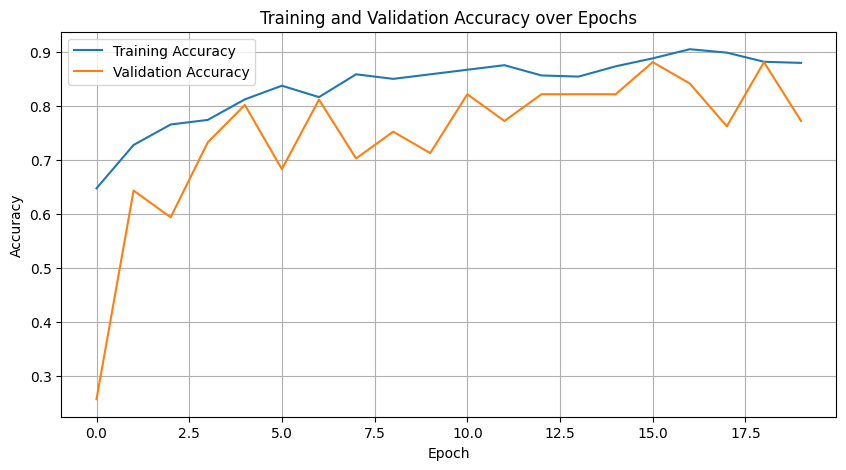

In [58]:
# 8 - Plotting and Final Analysis
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Training Loss')
plt.plot(range(len(history['val_loss'])), history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(len(history['train_acc'])), history['train_acc'], label='Training Accuracy')
plt.plot(range(len(history['val_acc'])), history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Classification Report:
                precision    recall  f1-score   support

 Boulder Coral       0.93      0.96      0.94        26
Branched Coral       0.97      0.93      0.95        41
   Plate Coral       1.00      0.82      0.90        17
    Soft Coral       0.78      0.95      0.86        19

      accuracy                           0.92       103
     macro avg       0.92      0.91      0.91       103
  weighted avg       0.93      0.92      0.92       103


Confusion Matrix:


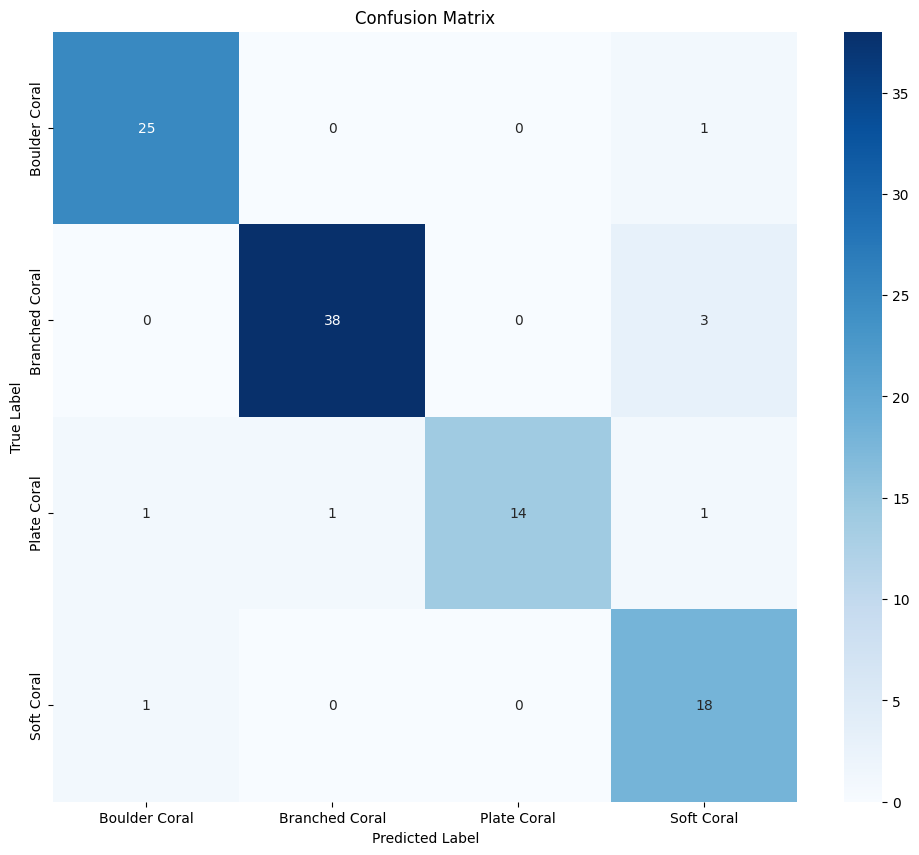

In [59]:
# 9 - Generate Classification Report and Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = [cls_name for cls_name in full_dataset.classes]

print("Classification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=class_names))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [60]:
# Assuming you have already run the training and evaluation steps,
# and have the 'model_ft' object in memory.

# 1. Save the entire model object
# This saves the model architecture, weights, and optimizer state
torch.save(model_ft, f'{model_name}_full_model.pth')
print(f"Full model object saved to {model_name}_full_model.pth")

# --- OR ---

# 2. Save only the model's state dictionary (weights)
# This is the recommended approach for smaller file sizes and portability
torch.save(model_ft.state_dict(), f'{model_name}_best_weights.pth')
print(f"Best model weights saved to {model_name}_best_weights.pth")

# To load the weights later:
# loaded_model = initialize_model(model_name, num_classes)
# loaded_model.load_state_dict(torch.load(f'{model_name}_best_weights.pth'))
# loaded_model.eval()

Full model object saved to inception_v3_full_model.pth
Best model weights saved to inception_v3_best_weights.pth
